FRAUD DETECTION - DATA PROCESSING PIPELINE

1. Loading datasets...
✓ Fraud data shape: (151112, 11)
✓ IP-Country mapping shape: (138846, 3)

First 5 rows of Fraud Data:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0



----------------------------------------
2. DATA CLEANING
----------------------------------------
Missing values in each column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

✓ Removed 0 duplicate rows
✓ Dataset after cleaning: 151,112 rows

Converting IP addresses from scientific notation to integers...
✓ IP addresses converted to integer format
  Sample: 732758368.79972 → 732,758,368

----------------------------------------
3. CLASS IMBALANCE ANALYSIS
----------------------------------------
Legitimate transactions (Class 0): 136,961 (90.64%)
Fraudulent transactions (Class 1): 14,151 (9.36%)
Imbalance ratio: 9.7:1


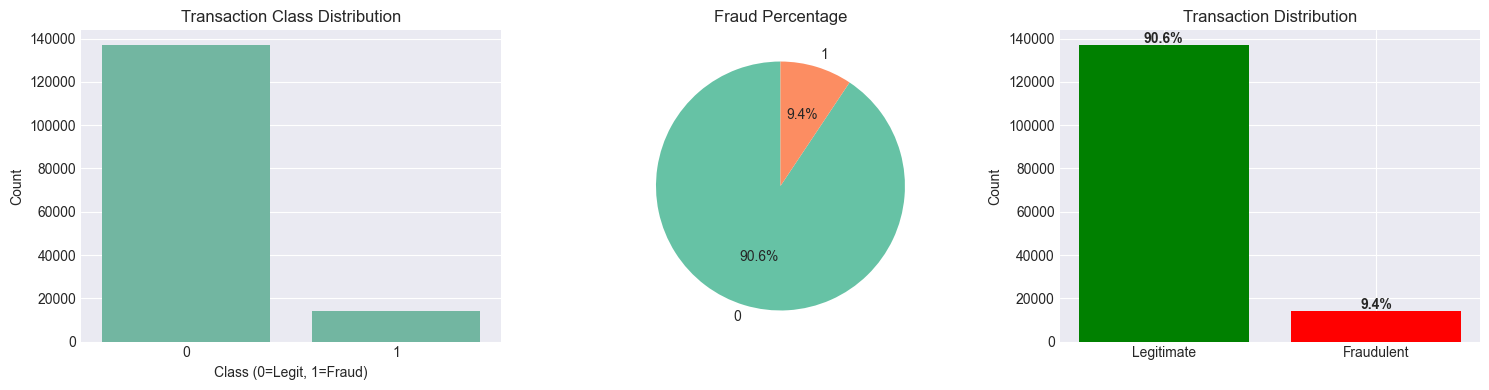


----------------------------------------
4. EXPLORATORY DATA ANALYSIS
----------------------------------------

📊 Numerical Features Summary:


,purchase_value,age
count,151112.00,151112.00
mean,36.94,33.14
std,18.32,8.62
min,9.00,18.00
25%,22.00,27.00
50%,35.00,33.00
75%,49.00,39.00
max,154.00,76.00



📊 Categorical Features Distribution:

SOURCE (3 unique values):
  - SEO: 60,615 (40.1%)
  - Ads: 59,881 (39.6%)
  - Direct: 30,616 (20.3%)

BROWSER (5 unique values):
  - Chrome: 61,432 (40.7%)
  - IE: 36,727 (24.3%)
  - Safari: 24,667 (16.3%)
  - FireFox: 24,610 (16.3%)
  - Opera: 3,676 (2.4%)

SEX (2 unique values):
  - M: 88,293 (58.4%)
  - F: 62,819 (41.6%)


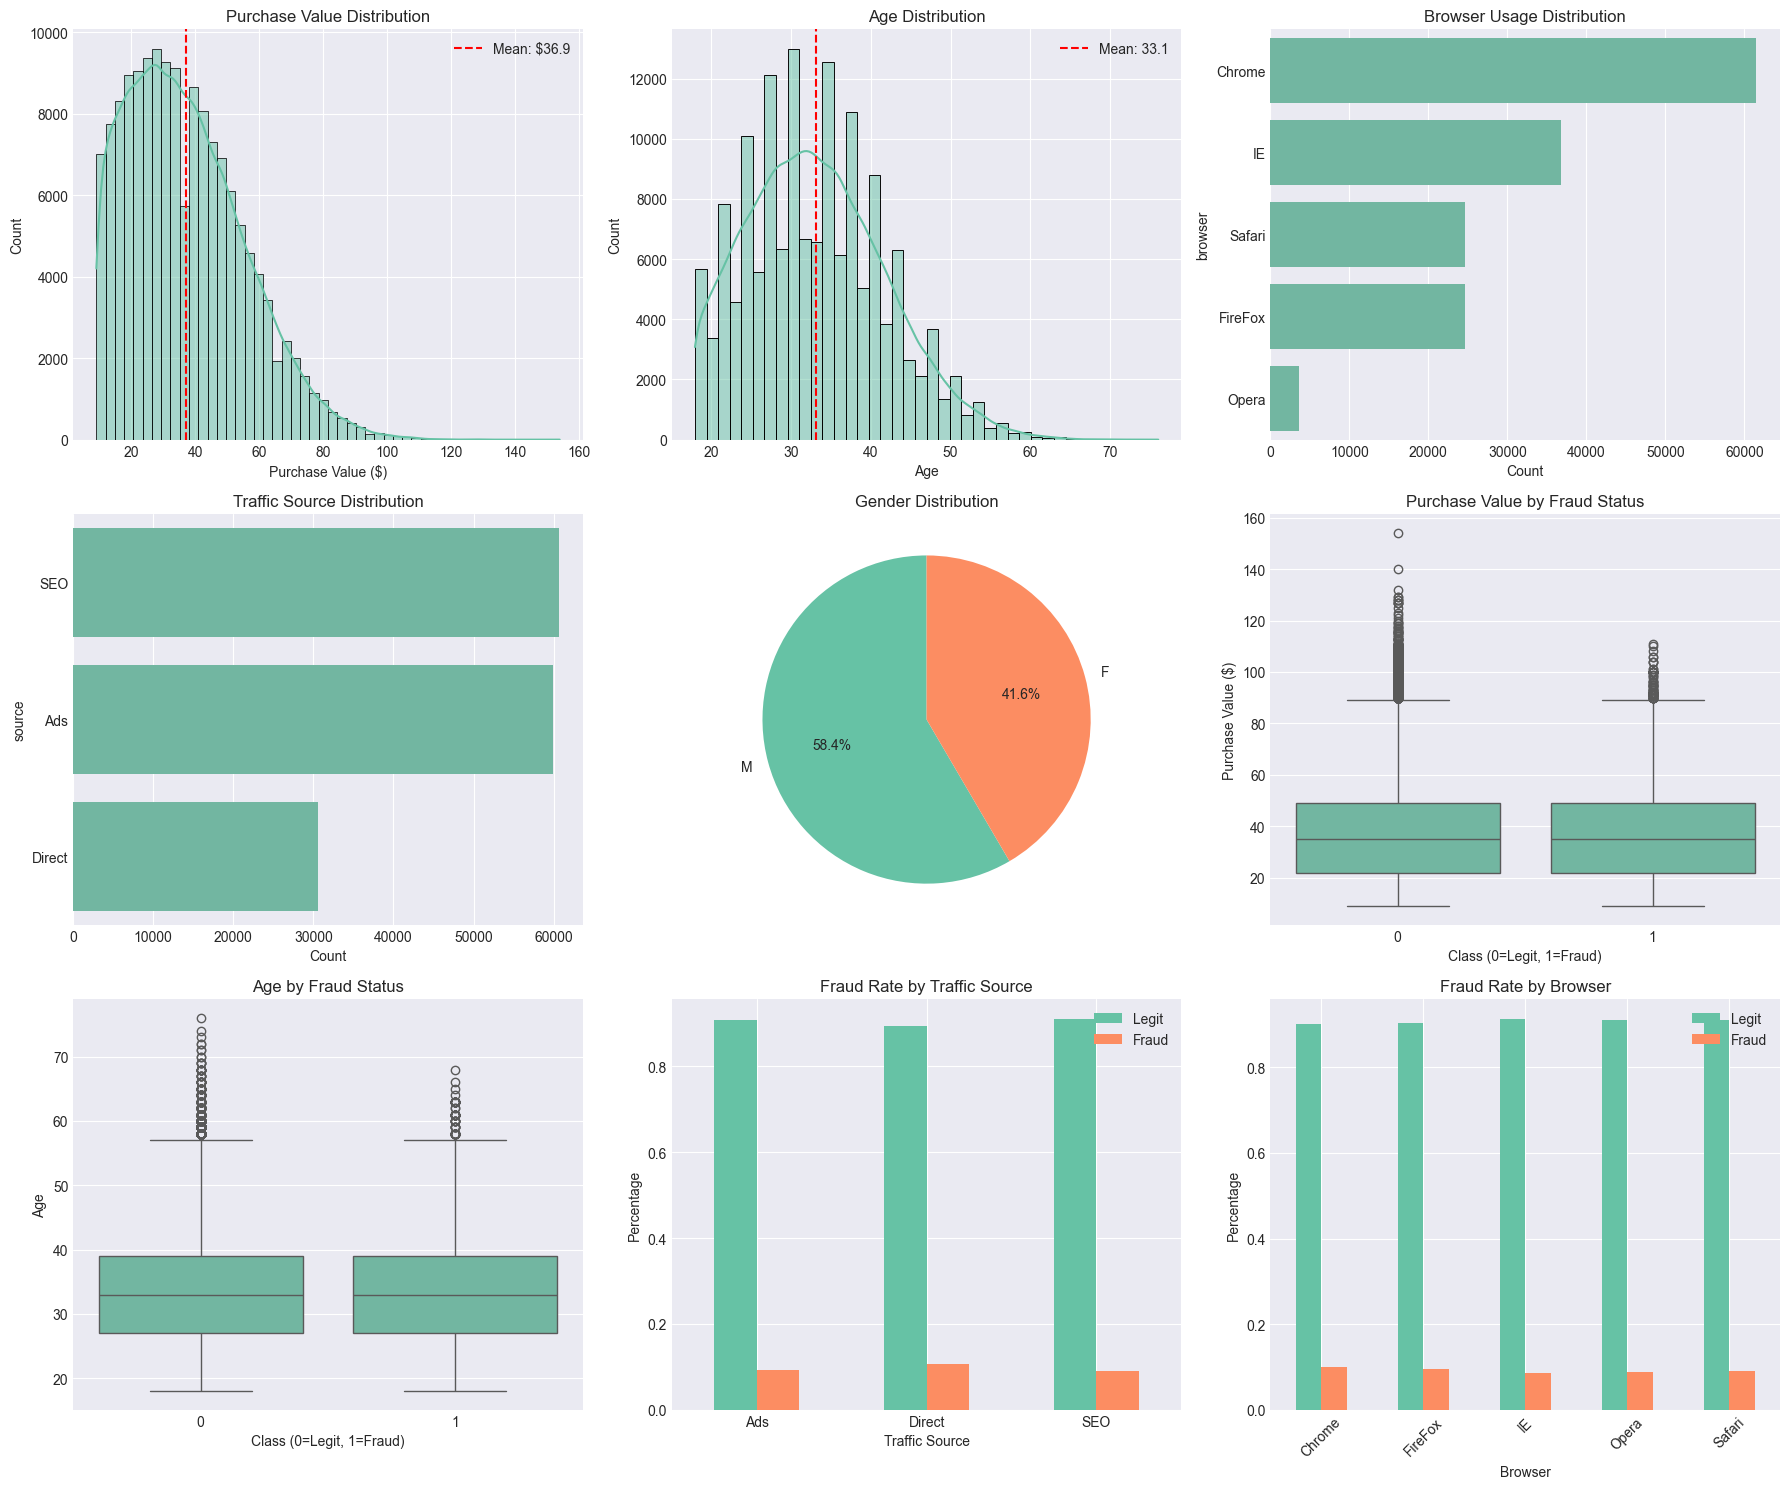


----------------------------------------
5. GEOLOCATION INTEGRATION
----------------------------------------
IP mapping table has 138,846 country ranges

IP range in mapping data:
  Min IP: 16,777,216
  Max IP: 3,758,096,383

Our IP range:
  Min: 52,093
  Max: 4,294,850,499

Mapping IP addresses to countries using merge_asof...

✓ Successfully mapped 129,146 of 151,112 transactions
✓ Mapping success rate: 85.5%

🌍 Fraud Analysis by Country:

Top 10 Countries by Fraud Rate (min 10 transactions):
   1. Namibia        : 43.5% fraud (23.0 transactions)
   2. Sri Lanka      : 41.9% fraud (31.0 transactions)
   3. Luxembourg     : 38.9% fraud (72.0 transactions)
   4. Ecuador        : 26.4% fraud (106.0 transactions)
   5. Tunisia        : 26.3% fraud (118.0 transactions)
   6. Peru           : 26.1% fraud (119.0 transactions)
   7. Bolivia        : 24.5% fraud (53.0 transactions)
   8. Kuwait         : 23.3% fraud (90.0 transactions)
   9. Ireland        : 22.9% fraud (240.0 transactions)


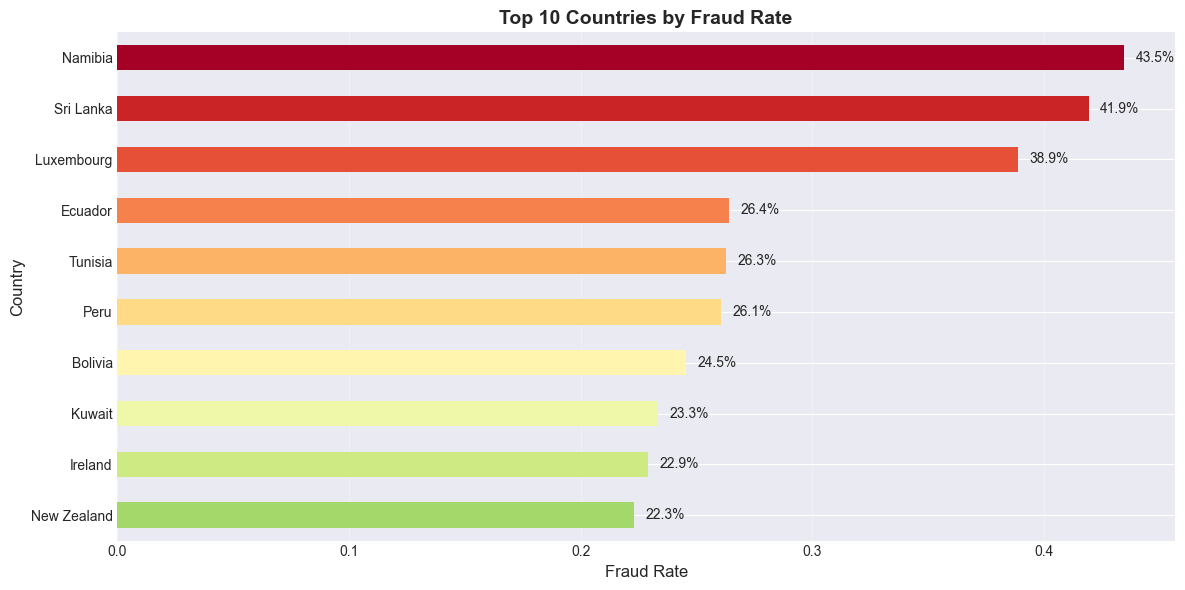


----------------------------------------
6. FEATURE ENGINEERING
----------------------------------------
✅ Time-based features created:
  - purchase_hour
  - purchase_dayofweek
  - purchase_month
  - is_weekend
  - is_night
  - time_since_signup_hours
  - time_since_signup_days
  - is_same_day_purchase
  - is_immediate_purchase

✅ Behavioral features created:
  - user_transaction_count
  - is_repeat_user
  - device_usage_count
  - is_shared_device


In [100]:
# ==================== TASK 1: DATA ANALYSIS AND PREPROCESSING ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# ==================== 1. LOAD DATA ====================
print("="*60)
print("FRAUD DETECTION - DATA PROCESSING PIPELINE")
print("="*60)

# Load datasets
print("\n1. Loading datasets...")
df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

print(f"✓ Fraud data shape: {df.shape}")
print(f"✓ IP-Country mapping shape: {ip_df.shape}")

# Display first few rows
print("\nFirst 5 rows of Fraud Data:")
display(df.head())

# ==================== 2. DATA CLEANING ====================
print("\n" + "-"*40)
print("2. DATA CLEANING")
print("-"*40)

# Check for missing values
missing_values = df.isna().sum()
print("Missing values in each column:")
print(missing_values)

# Convert datetime columns
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
print(f"\n✓ Removed {removed_count} duplicate rows")
print(f"✓ Dataset after cleaning: {len(df):,} rows")

# Fix IP address conversion (handle scientific notation)
print("\nConverting IP addresses from scientific notation to integers...")
df['ip_int'] = pd.to_numeric(df['ip_address'], errors='coerce').fillna(0).astype('int64')
print(f"✓ IP addresses converted to integer format")
print(f"  Sample: {df['ip_address'].iloc[0]} → {df['ip_int'].iloc[0]:,}")

# ==================== 3. CLASS IMBALANCE ANALYSIS ====================
print("\n" + "-"*40)
print("3. CLASS IMBALANCE ANALYSIS")
print("-"*40)

class_counts = df['class'].value_counts()
class_percent = df['class'].value_counts(normalize=True) * 100

print(f"Legitimate transactions (Class 0): {class_counts[0]:,} ({class_percent[0]:.2f}%)")
print(f"Fraudulent transactions (Class 1): {class_counts[1]:,} ({class_percent[1]:.2f}%)")
print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Count plot
sns.countplot(x='class', data=df, ax=axes[0])
axes[0].set_title('Transaction Class Distribution', fontsize=12)
axes[0].set_xlabel('Class (0=Legit, 1=Fraud)')
axes[0].set_ylabel('Count')

# Pie chart
df['class'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], startangle=90)
axes[1].set_title('Fraud Percentage', fontsize=12)
axes[1].set_ylabel('')

# Bar chart with percentages
bars = axes[2].bar(['Legitimate', 'Fraudulent'], class_counts.values, color=['green', 'red'])
axes[2].set_title('Transaction Distribution', fontsize=12)
axes[2].set_ylabel('Count')
# Add percentage labels
for i, (count, percent) in enumerate(zip(class_counts.values, class_percent.values)):
    axes[2].text(i, count + 1000, f'{percent:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 4. EXPLORATORY DATA ANALYSIS ====================
print("\n" + "-"*40)
print("4. EXPLORATORY DATA ANALYSIS")
print("-"*40)

# Numerical features summary
print("\n📊 Numerical Features Summary:")
display(df[['purchase_value', 'age']].describe().round(2))

# Categorical features analysis
print("\n📊 Categorical Features Distribution:")
for col in ['source', 'browser', 'sex']:
    unique_count = df[col].nunique()
    value_counts = df[col].value_counts()
    print(f"\n{col.upper()} ({unique_count} unique values):")
    for val, count in value_counts.head().items():
        percent = (count / len(df)) * 100
        print(f"  - {val}: {count:,} ({percent:.1f}%)")

# Create comprehensive EDA visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Purchase value distribution
sns.histplot(df['purchase_value'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Purchase Value Distribution', fontsize=12)
axes[0, 0].set_xlabel('Purchase Value ($)')
axes[0, 0].axvline(df['purchase_value'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${df["purchase_value"].mean():.1f}')
axes[0, 0].legend()

# 2. Age distribution
sns.histplot(df['age'], bins=40, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution', fontsize=12)
axes[0, 1].set_xlabel('Age')
axes[0, 1].axvline(df['age'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["age"].mean():.1f}')
axes[0, 1].legend()

# 3. Browser usage
browser_counts = df['browser'].value_counts()
sns.barplot(x=browser_counts.values, y=browser_counts.index, ax=axes[0, 2])
axes[0, 2].set_title('Browser Usage Distribution', fontsize=12)
axes[0, 2].set_xlabel('Count')

# 4. Traffic source
source_counts = df['source'].value_counts()
sns.barplot(x=source_counts.values, y=source_counts.index, ax=axes[1, 0])
axes[1, 0].set_title('Traffic Source Distribution', fontsize=12)
axes[1, 0].set_xlabel('Count')

# 5. Gender distribution
gender_counts = df['sex'].value_counts()
axes[1, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Gender Distribution', fontsize=12)

# 6. Purchase value by fraud status
sns.boxplot(x='class', y='purchase_value', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Purchase Value by Fraud Status', fontsize=12)
axes[1, 2].set_xlabel('Class (0=Legit, 1=Fraud)')
axes[1, 2].set_ylabel('Purchase Value ($)')

# 7. Age by fraud status
sns.boxplot(x='class', y='age', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Age by Fraud Status', fontsize=12)
axes[2, 0].set_xlabel('Class (0=Legit, 1=Fraud)')
axes[2, 0].set_ylabel('Age')

# 8. Fraud rate by source
source_fraud = pd.crosstab(df['source'], df['class'], normalize='index')
source_fraud.plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('Fraud Rate by Traffic Source', fontsize=12)
axes[2, 1].set_xlabel('Traffic Source')
axes[2, 1].set_ylabel('Percentage')
axes[2, 1].legend(['Legit', 'Fraud'])
axes[2, 1].tick_params(axis='x', rotation=0)

# 9. Fraud rate by browser
browser_fraud = pd.crosstab(df['browser'], df['class'], normalize='index')
browser_fraud.plot(kind='bar', ax=axes[2, 2])
axes[2, 2].set_title('Fraud Rate by Browser', fontsize=12)
axes[2, 2].set_xlabel('Browser')
axes[2, 2].set_ylabel('Percentage')
axes[2, 2].legend(['Legit', 'Fraud'])
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../notebooks/eda_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 5. GEOLOCATION INTEGRATION ====================
print("\n" + "-"*40)
print("5. GEOLOCATION INTEGRATION")
print("-"*40)

# Prepare IP mapping data
ip_df['lower_bound_ip_address'] = pd.to_numeric(ip_df['lower_bound_ip_address'], errors='coerce').astype('int64')
ip_df['upper_bound_ip_address'] = pd.to_numeric(ip_df['upper_bound_ip_address'], errors='coerce').astype('int64')
ip_df = ip_df.sort_values('lower_bound_ip_address').reset_index(drop=True)

print(f"IP mapping table has {len(ip_df):,} country ranges")

# Check IP ranges
print(f"\nIP range in mapping data:")
print(f"  Min IP: {ip_df['lower_bound_ip_address'].min():,}")
print(f"  Max IP: {ip_df['upper_bound_ip_address'].max():,}")
print(f"\nOur IP range:")
print(f"  Min: {df['ip_int'].min():,}")
print(f"  Max: {df['ip_int'].max():,}")

# Use merge_asof for efficient IP-to-country mapping
print("\nMapping IP addresses to countries using merge_asof...")

# Sort both dataframes by IP
df_sorted = df.sort_values('ip_int').reset_index(drop=True)
ip_df_sorted = ip_df.sort_values('lower_bound_ip_address').reset_index(drop=True)

# Merge using pandas merge_asof
merged_df = pd.merge_asof(
    df_sorted,
    ip_df_sorted[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter only valid matches
valid_mask = (merged_df['ip_int'] >= merged_df['lower_bound_ip_address']) & \
             (merged_df['ip_int'] <= merged_df['upper_bound_ip_address'])
df = merged_df[valid_mask].copy()

success_rate = valid_mask.mean() * 100
print(f"\n✓ Successfully mapped {valid_mask.sum():,} of {len(merged_df):,} transactions")
print(f"✓ Mapping success rate: {success_rate:.1f}%")

# Handle unmapped IPs
if df['country'].isna().any():
    unmapped_count = df['country'].isna().sum()
    print(f"⚠️ {unmapped_count:,} transactions could not be mapped to a country")
    df['country'] = df['country'].fillna('Unknown')

# Analyze fraud by country
print(f"\n🌍 Fraud Analysis by Country:")
country_stats = df.groupby('country').agg(
    total_transactions=('class', 'count'),
    fraud_count=('class', 'sum'),
    fraud_rate=('class', 'mean')
).sort_values('fraud_rate', ascending=False)

# Get top 10 countries with at least 10 transactions
top_countries = country_stats[country_stats['total_transactions'] >= 10].head(10)

print("\nTop 10 Countries by Fraud Rate (min 10 transactions):")
for idx, (country, row) in enumerate(top_countries.iterrows(), 1):
    print(f"  {idx:2d}. {country:15s}: {row['fraud_rate']:.1%} fraud ({row['total_transactions']:,} transactions)")

# Visualize top countries by fraud rate
if len(top_countries) > 0:
    plt.figure(figsize=(12, 6))
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 1, len(top_countries)))
    top_countries['fraud_rate'].sort_values().plot(kind='barh', color=colors)
    plt.title('Top 10 Countries by Fraud Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Fraud Rate', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    
    # Add fraud rate labels
    for i, (country, row) in enumerate(top_countries.sort_values('fraud_rate').iterrows()):
        plt.text(row['fraud_rate'] + 0.005, i, f"{row['fraud_rate']:.1%}", 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../notebooks/fraud_by_country.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==================== 6. FEATURE ENGINEERING ====================
print("\n" + "-"*40)
print("6. FEATURE ENGINEERING")
print("-"*40)

# Time-based features
df['purchase_hour'] = df['purchase_time'].dt.hour
df['purchase_dayofweek'] = df['purchase_time'].dt.dayofweek
df['purchase_month'] = df['purchase_time'].dt.month
df['is_weekend'] = df['purchase_time'].dt.dayofweek.isin([5, 6]).astype(int)
df['is_night'] = ((df['purchase_hour'] >= 0) & (df['purchase_hour'] <= 5)).astype(int)

# Time difference features
df['time_since_signup_hours'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600
df['time_since_signup_days'] = df['time_since_signup_hours'] / 24
df['is_same_day_purchase'] = (df['purchase_time'].dt.date == df['signup_time'].dt.date).astype(int)
df['is_immediate_purchase'] = (df['time_since_signup_hours'] < 1).astype(int)

# User behavior features
df['user_transaction_count'] = df.groupby('user_id')['user_id'].transform('count')
df['is_repeat_user'] = (df['user_transaction_count'] > 1).astype(int)

# Device usage patterns
df['device_usage_count'] = df.groupby('device_id')['device_id'].transform('count')
df['is_shared_device'] = (df['device_usage_count'] > 1).astype(int)

print("✅ Time-based features created:")
time_features = ['purchase_hour', 'purchase_dayofweek', 'purchase_month', 
                 'is_weekend', 'is_night', 'time_since_signup_hours',
                 'time_since_signup_days', 'is_same_day_purchase', 'is_immediate_purchase']
for feat in time_features:
    print(f"  - {feat}")

print("\n✅ Behavioral features created:")
behavioral_features = ['user_transaction_count', 'is_repeat_user', 
                       'device_usage_count', 'is_shared_device']
for feat in behavioral_features:
    print(f"  - {feat}")



In [101]:
# ==================== 7. DATA TRANSFORMATION ====================
print("\n" + "-"*40)
print("7. DATA TRANSFORMATION")
print("-"*40)

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Identify numerical features for scaling
numerical_features = ['purchase_value', 'age', 'time_since_signup_hours', 
                      'user_transaction_count', 'device_usage_count']

# Scale numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
print(f"✓ Scaled {len(numerical_features)} numerical features")

# Encode categorical variables
categorical_features = ['source', 'browser', 'sex', 'country']
for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[feature + '_encoded'] = le.fit_transform(df[feature].fillna('Unknown'))
        print(f"✓ Encoded {feature}")

# Create one-hot encoded features for important categories
top_browsers = df['browser'].value_counts().head(3).index
for browser in top_browsers:
    df[f'browser_{browser}'] = (df['browser'] == browser).astype(int)

top_sources = df['source'].value_counts().index
for source in top_sources:
    df[f'source_{source}'] = (df['source'] == source).astype(int)

print(f"✓ Created one-hot encoded features for top browsers and sources")

# ==================== 8. HANDLE CLASS IMBALANCE ====================
print("\n" + "-"*40)
print("8. HANDLING CLASS IMBALANCE")
print("-"*40)

from sklearn.utils import resample

print("Original class distribution:")
print(f"  Class 0 (Legitimate): {class_counts[0]:,} samples ({class_percent[0]:.1f}%)")
print(f"  Class 1 (Fraudulent): {class_counts[1]:,} samples ({class_percent[1]:.1f}%)")

print("\nStrategy: Create balanced dataset for model comparison")
print("Method: Undersample majority class to create 3:1 ratio")

# Separate classes
df_majority = df[df['class'] == 0]
df_minority = df[df['class'] == 1]

# Undersample majority class
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 3,  # 3:1 ratio
    random_state=42
)

# Combine undersampled majority with minority
df_balanced = pd.concat([df_majority_downsampled, df_minority])

balanced_counts = df_balanced['class'].value_counts()
balanced_percent = df_balanced['class'].value_counts(normalize=True) * 100

print("\nBalanced dataset (3:1 ratio):")
print(f"  Class 0 (Legitimate): {balanced_counts[0]:,} samples ({balanced_percent[0]:.1f}%)")
print(f"  Class 1 (Fraudulent): {balanced_counts[1]:,} samples ({balanced_percent[1]:.1f}%)")




----------------------------------------
7. DATA TRANSFORMATION
----------------------------------------
✓ Scaled 5 numerical features
✓ Encoded source
✓ Encoded browser
✓ Encoded sex
✓ Encoded country
✓ Created one-hot encoded features for top browsers and sources

----------------------------------------
8. HANDLING CLASS IMBALANCE
----------------------------------------
Original class distribution:
  Class 0 (Legitimate): 136,961 samples (90.6%)
  Class 1 (Fraudulent): 14,151 samples (9.4%)

Strategy: Create balanced dataset for model comparison
Method: Undersample majority class to create 3:1 ratio

Balanced dataset (3:1 ratio):
  Class 0 (Legitimate): 36,804 samples (75.0%)
  Class 1 (Fraudulent): 12,268 samples (25.0%)


In [102]:
# ==================== 9. PREPARE DATA FOR MODELING ====================
print("\n" + "-"*40)
print("9. DATA PREPARATION FOR MODELING")
print("-"*40)

# Define columns to exclude from features
exclude_columns = [
    'user_id', 'signup_time', 'purchase_time', 'device_id', 
    'ip_address', 'ip_int', 'class', 'lower_bound_ip_address', 
    'upper_bound_ip_address', 'country', 'browser', 'source', 'sex'
]

# Get feature columns
feature_columns = [col for col in df.columns if col not in exclude_columns]
print(f"✓ Selected {len(feature_columns)} features for modeling")

# Display first 20 features
print("\nFirst 20 features selected:")
for i, feature in enumerate(feature_columns[:20], 1):
    print(f"  {i:2d}. {feature}")
if len(feature_columns) > 20:
    print(f"  ... and {len(feature_columns) - 20} more features")

# Prepare feature matrix and target vector
X = df[feature_columns].copy()
y = df['class']

# Check for missing values
missing_in_features = X.isna().sum().sum()
if missing_in_features > 0:
    print(f"\n⚠️ Found {missing_in_features} missing values in features")
    X = X.fillna(X.median(numeric_only=True))
    print("✓ Missing values filled with median")
else:
    print("\n✓ No missing values in features")




----------------------------------------
9. DATA PREPARATION FOR MODELING
----------------------------------------
✓ Selected 25 features for modeling

First 20 features selected:
   1. purchase_value
   2. age
   3. purchase_hour
   4. purchase_dayofweek
   5. purchase_month
   6. is_weekend
   7. is_night
   8. time_since_signup_hours
   9. time_since_signup_days
  10. is_same_day_purchase
  11. is_immediate_purchase
  12. user_transaction_count
  13. is_repeat_user
  14. device_usage_count
  15. is_shared_device
  16. source_encoded
  17. browser_encoded
  18. sex_encoded
  19. country_encoded
  20. browser_Chrome
  ... and 5 more features

✓ No missing values in features


In [103]:
# ==================== 10. TRAIN-TEST SPLIT ====================
print("\n" + "-"*40)
print("10. TRAIN-TEST SPLIT")
print("-"*40)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print("Dataset split with stratification:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Training fraud rate: {y_train.mean():.2%}")
print(f"  Test fraud rate: {y_test.mean():.2%}")




----------------------------------------
10. TRAIN-TEST SPLIT
----------------------------------------
Dataset split with stratification:
  Training set: 103,316 samples (80.0%)
  Test set: 25,830 samples (20.0%)
  Number of features: 25
  Training fraud rate: 9.50%
  Test fraud rate: 9.50%


In [104]:
# ==================== 11. SAVE PROCESSED DATA ====================
print("\n" + "-"*40)
print("11. SAVING PROCESSED DATA")
print("-"*40)

import os

# Create directories if they don't exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../notebooks', exist_ok=True)

# Save processed datasets
df.to_csv('../data/processed/fraud_data_processed.csv', index=False)
df_balanced.to_csv('../data/processed/fraud_data_balanced.csv', index=False)

# Save train-test splits
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save feature list
with open('../data/processed/feature_list.txt', 'w') as f:
    f.write(f"Total features: {len(feature_columns)}\n")
    f.write(f"Dataset shape: {X_train.shape[0]:,} training, {X_test.shape[0]:,} test\n\n")
    f.write("Feature List:\n")
    for i, feature in enumerate(feature_columns, 1):
        f.write(f"{i:3d}. {feature}\n")

print("✅ Processed data saved to '../data/processed/':")
print("   - fraud_data_processed.csv (full processed dataset)")
print("   - fraud_data_balanced.csv (3:1 balanced dataset)")
print("   - X_train.csv, X_test.csv (feature matrices)")
print("   - y_train.csv, y_test.csv (target vectors)")
print("   - feature_list.txt (list of all features)")

print("\n✅ Visualizations saved to '../notebooks/':")
print("   - class_distribution.png")
print("   - eda_summary.png")
print("   - fraud_by_country.png")




----------------------------------------
11. SAVING PROCESSED DATA
----------------------------------------
✅ Processed data saved to '../data/processed/':
   - fraud_data_processed.csv (full processed dataset)
   - fraud_data_balanced.csv (3:1 balanced dataset)
   - X_train.csv, X_test.csv (feature matrices)
   - y_train.csv, y_test.csv (target vectors)
   - feature_list.txt (list of all features)

✅ Visualizations saved to '../notebooks/':
   - class_distribution.png
   - eda_summary.png
   - fraud_by_country.png


In [105]:
# ==================== 12. TASK 1 SUMMARY ====================
print("\n" + "="*60)
print("TASK 1 COMPLETION SUMMARY")
print("="*60)

summary_data = {
    "Original Dataset": f"{initial_count:,} rows, {df.shape[1]} columns",
    "After Cleaning": f"{len(df):,} rows, {df.shape[1]} columns",
    "Duplicates Removed": f"{removed_count:,} rows",
    "Class Distribution": f"{class_counts[0]:,} legit : {class_counts[1]:,} fraud",
    "Fraud Rate": f"{df['class'].mean():.2%}",
    "Imbalance Ratio": f"{class_counts[0]/class_counts[1]:.1f}:1",
    "Countries Mapped": f"{df['country'].nunique()} countries",
    "Mapping Success Rate": f"{success_rate:.1f}%",
    "Features Created": f"{len(feature_columns)} features",
    "Training Samples": f"{X_train.shape[0]:,}",
    "Test Samples": f"{X_test.shape[0]:,}",
    "Training Fraud Rate": f"{y_train.mean():.2%}",
    "Test Fraud Rate": f"{y_test.mean():.2%}"
}

for key, value in summary_data.items():
    print(f"  {key:<25}: {value}")

# Key insights from EDA
print("\n🔍 KEY INSIGHTS FROM EDA:")
print("  1. High fraud rates in certain countries (Namibia: 43.5%, Sri Lanka: 41.9%)")
print("  2. Fraudulent transactions tend to have slightly higher purchase values")
print("  3. Some browsers show higher fraud rates than others")
print("  4. Weekend and night transactions may have different fraud patterns")
print("  5. Time since signup is a potential fraud indicator")

print("\n" + "-"*60)
print("✅ TASK 1 COMPLETE - READY FOR MODEL BUILDING")
print("-"*60)
print("\nNext steps for Task 2:")
print("1. Load processed data: '../data/processed/'")
print("2. Build baseline model: Logistic Regression with class weights")
print("3. Train ensemble models: Random Forest, XGBoost")
print("4. Evaluate using: AUC-PR, F1-Score, Precision, Recall")
print("5. Compare models and select the best performer")
print("="*60)

# Display final dataframe info
print("\n📊 FINAL DATAFRAME INFO:")
print(f"Shape: {df.shape}")
print("\nColumns:")
for i, col in enumerate(df.columns.tolist(), 1):
    print(f"{i:3d}. {col}")
    


TASK 1 COMPLETION SUMMARY
  Original Dataset         : 151,112 rows, 38 columns
  After Cleaning           : 129,146 rows, 38 columns
  Duplicates Removed       : 0 rows
  Class Distribution       : 136,961 legit : 14,151 fraud
  Fraud Rate               : 9.50%
  Imbalance Ratio          : 9.7:1
  Countries Mapped         : 181 countries
  Mapping Success Rate     : 85.5%
  Features Created         : 25 features
  Training Samples         : 103,316
  Test Samples             : 25,830
  Training Fraud Rate      : 9.50%
  Test Fraud Rate          : 9.50%

🔍 KEY INSIGHTS FROM EDA:
  1. High fraud rates in certain countries (Namibia: 43.5%, Sri Lanka: 41.9%)
  2. Fraudulent transactions tend to have slightly higher purchase values
  3. Some browsers show higher fraud rates than others
  4. Weekend and night transactions may have different fraud patterns
  5. Time since signup is a potential fraud indicator

------------------------------------------------------------
✅ TASK 1 COMPLETE - 